In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [ ]:
def create_synthetic_data(N=100):
    """
    Create a simple 2D dataset with two clusters:
    cluster 0 around (-2, -2) and cluster 1 around (+2, +2).
    """
    np.random.seed(42)  # for reproducibility
    
    # Class 0: centered around (-2, -2)
    X0 = np.random.randn(N//2, 2) + np.array([-2, -2])
    y0 = np.zeros((N//2, 1))  # label 0

    # Class 1: centered around (+2, +2)
    X1 = np.random.randn(N//2, 2) + np.array([2, 2])
    y1 = np.ones((N//2, 1))   # label 1

    # Combine and shuffle
    X = np.vstack([X0, X1])       # shape: (N, 2)
    y = np.vstack([y0, y1])       # shape: (N, 1)

    # Shuffle the dataset
    indices = np.arange(N)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    return X, y

# Quick test:
# X, y = create_synthetic_data(200)
# print(X.shape, y.shape)

(200, 2) (200, 1)


In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict_proba(X, w, b):
    z = np.dot(X, w) + b
    return sigmoid(z).reshape(-1, 1)

def predict_class(X, w, b, threshold=0.5):
    probs = predict_proba(X, w, b)
    return (probs >= threshold).astype(int)

def binary_cross_entropy(y_true, y_pred):
    eps = 1e-10
    y_pred = np.clip(y_pred, eps, 1 - eps)
    N = y_true.shape[0]
    loss = -1/N * np.sum(y_true * np.log(y_pred) + (1 - y_true)*np.log(1 - y_pred))
    return loss

def gradient_descent_step(X, y, w, b, learning_rate=0.01):
    N = X.shape[0]
    
    y_pred = predict_proba(X, w, b)  
    
    loss = binary_cross_entropy(y, y_pred)
    
    # Error for gradient
    error = (y_pred - y)  
    
    # Gradients
    grad_w = (1/N) * np.dot(X.T, error).ravel()   
    grad_b = (1/N) * np.sum(error)
    
    w -= learning_rate * grad_w
    b -= learning_rate * grad_b
    
    return w, b, loss

def train(X, y, w_init=None, b_init=0.0, learning_rate=0.001, epochs=100):
    d = X.shape[1]  
    if w_init is None:
        w = np.zeros(d)  
    else:
        w = w_init.copy()
    b = b_init
    
    history = []
    
    for _ in range(epochs):
        y_pred = predict_proba(X, w, b)
        current_loss = binary_cross_entropy(y, y_pred)
        history.append((w.copy(), b, current_loss))
        
        # 2. One step of gradient descent
        w, b, _ = gradient_descent_step(X, y, w, b, learning_rate)
    
    # After the final step, record the last state again if desired
    final_loss = binary_cross_entropy(y, predict_proba(X, w, b))
    history.append((w.copy(), b, final_loss))
    
    return history

In [9]:
def animate_logistic_regression(X, y, history, interval=500, save_as=None):
    """
    Creates an animation of the logistic regression boundary
    evolving over training steps.

    history: list of (w, b, loss)
    """
    fig, ax = plt.subplots(figsize=(6, 6))

    # Scatter data
    ax.scatter(X[y[:,0]==0, 0], X[y[:,0]==0, 1], color='blue', label='Class 0')
    ax.scatter(X[y[:,0]==1, 0], X[y[:,0]==1, 1], color='red', label='Class 1')
    ax.legend()
    ax.set_title("Logistic Regression Training")
    ax.grid(True)

    # Initialize a line object for the boundary
    line, = ax.plot([], [], 'g-', label='Decision Boundary')
    
    # Pre-calc boundaries for consistent display
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    
    def update(frame):
        w, b, loss = history[frame]
        ax.set_title(f"Step {frame+1}/{len(history)}, Loss={loss:.4f}")
        x_vals = np.linspace(x_min, x_max, 100)

        if abs(w[1]) > 1e-9:
            x2_vals = -(b + w[0]*x_vals) / w[1]
            line.set_xdata(x_vals)
            line.set_ydata(x2_vals)
        else:
            # If w[1] is near zero, the boundary is vertical: w[0]*x0 + b=0 => x0= -b/w[0]
            x0_const = -b / (w[0] + 1e-9)
            line.set_xdata([x0_const, x0_const])
            line.set_ydata([y_min, y_max])
        
        return line,

    anim = FuncAnimation(
        fig,
        update,
        frames=len(history),
        interval=interval,
        blit=False
    )

    if save_as is not None:
        anim.save(save_as, writer='ffmpeg', fps=2)
    
    return anim

In [17]:
X, y = create_synthetic_data(N=1000)

history = train(
    X, y,
    w_init=None,
    b_init=0.0,
    learning_rate=0.001,
    epochs=100  
)

final_w, final_b, final_loss = history[-1]
print(f"Final w={final_w}, b={final_b}, loss={final_loss:.4f}")

Final w=[0.09091092 0.090445  ], b=-0.00010173674574052618, loss=0.5282


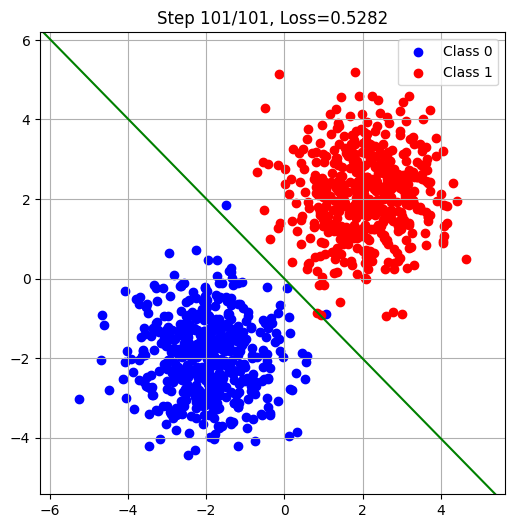

In [18]:
anim = animate_logistic_regression(X, y, history, interval=500, save_as="logreg_anim.gif")
plt.show()